# Libraries

In [1]:
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np

# for teacher
import random

from sklearn.model_selection import train_test_split

# Side variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
base_type = np.float32
torch_type = torch.float32
batch_size = 128
window_length = 256 # Data points will hold 1024 tokens of observations (should be 1/4 average song length in tokens, remember to remove outliers)
window_step_size = 1 # Sliding window will move this much each time (higher numbers means less data, but less overfitting to similar data)


Using device: cuda


# Load Data / Tokenize

In [2]:
# load
data = []
with open("./out.txt", "r") as file:
    data = file.read().splitlines()

print(data[5:10])

['noteD4', '1/2', '</simul>', '<simul>', 'rest']


In [3]:
# now tokenize
unique_tokens = set(list(data) + ["PAD"])
print(len(unique_tokens))
# mapping
note_to_token = {note: idx for idx, note in enumerate(unique_tokens)}
token_to_note = {idx: note for note, idx in note_to_token.items()}


115


# Data Preprocessing

In [4]:
end_token = note_to_token["<end_song>"]
pad_token = note_to_token["PAD"]
print(end_token)
print(pad_token)

5
99


In [5]:
data_inp = [note_to_token[tok] for tok in data]


# Assume already tokenized (this is for transformer, must be adapted for other models)
class MusicDataset(Dataset):
    def __init__(self, data, window_length, step_size):
        self.temp_data = data
        self.window_length = window_length
        self.step_size = step_size
        self.final_data = self.apply_window()

    def apply_window(self):
        train_examples = []
        song_data = []
        cur_seq = []

        # first split data by songs
        for tok in self.temp_data:
            cur_seq.append(tok)
            if(tok == end_token):
                song_data.append(cur_seq)
                cur_seq = []
        
        # then apply sliding windows
        for song in song_data:
            idx = 0
            # create sliding windows
            for start_idx in range(0, len(song) - self.window_length + 1, self.step_size):
                end_idx = start_idx + self.window_length
                idx = end_idx # store most recent end_idx
                train_example = song[start_idx:end_idx] # training of length window_length
                train_examples.append(train_example)
            
            # now add ending and pad (so model can learn how to finish predicting)
            train_example = song[idx:]
            train_example += [0] * (self.window_length - len(train_example))
            train_examples.append(train_example)


        return train_examples

    #def apply_window(self):
    #    # return sliding window data + labels
    #    train_examples = []
    #    # cycle through each window configuration, calculating start index and end index
    #    for start_idx in range(0, len(self.temp_data) - self.window_length + 1, self.step_size):
    #        end_idx = start_idx + self.window_length
    #        train_example = self.temp_data[start_idx:end_idx] # training of length window_length
    #        train_examples.append(train_example)
    #        
    #    return train_examples
    
                

    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, idx):
        window = self.final_data[idx]

        return torch.tensor(window).to(device)
    

dataset = MusicDataset(data_inp, window_length, window_step_size)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

vocab_len = len(unique_tokens)


In [6]:
# generate music
# for now, generate a fixed length, if we add start and end tokens then we can also do that
def generate_music(model, start_tokens, temperature=1.0, num_to_generate=window_length):
    model.eval()

    predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))
    # iteratively predict then add to start_tokens
    for i in range(num_to_generate):
        with torch.no_grad():
            # grab most recent tokens
            logits = model(predicted_tokens[:, -(window_length):]) # (1, len(predicted_tokens), num_tokens)
            logits = logits[:, -1, :] # grabs last token 
            probs = torch.softmax(logits / temperature, dim=-1) # (1, num_tokens)
            pred_token = torch.multinomial(probs, num_samples=1) # (1, 1)

        predicted_tokens = torch.cat([predicted_tokens, pred_token], dim=1) # (1, len(current sequence length))

    return predicted_tokens.squeeze(0).tolist()


In [7]:
from matplotlib import pyplot as plt
def Display_Plot(train_loss, valid_loss, model_name):
    # Get error metrics
    train_err = np.array(train_loss)
    val_err = np.array(valid_loss)
    # Plot training and test errors
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_err) + 1), train_err, label="train_loss", color="red", linewidth=2)
    plt.plot(range(1, len(val_err) + 1), val_err, label="val_loss", color="green", linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(model_name)
    plt.legend()

    plt.show()

# RNN

In [32]:
# RNN Variables
input_size = 256
hidden_size = 512 # larger embed size may require larger dropout
dropout = 0.2
lr = 1e-4
epochs = 20

In [11]:
class Music_RNN(nn.Module):
    def __init__(self, vocab_len, input_size, hidden_size, dropout):
        super(Music_RNN, self).__init__()
        self.embed = nn.Embedding(vocab_len, input_size)
        self.RNN = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout)
        self.layernorm = nn.LayerNorm(hidden_size)
        self.drop = nn.Dropout(dropout)
        self.ff = nn.Linear(hidden_size, vocab_len) # predicting next input autoregressively

    def forward(self, x):
        # x should be (batch_size, seq_len)
        x = self.embed(x) # (batch_size, seq_len, input_size)
        x, _ = self.RNN(x) # (batch_size, seq_len, hidden_size)
        x = self.layernorm(x)
        x = self.drop(x)
        x_pred = self.ff(x) # batch_size, seq_len, vocab_len)

        return x_pred 

In [12]:
model_rnn = Music_RNN(vocab_len, input_size, hidden_size, dropout).to(device)

Epoch: 0, Loss: 3.6892072796474045
Validation loss: 3.0211245251256367
Epoch: 1, Loss: 2.9130229546794393
Validation loss: 2.693679952344229
Epoch: 2, Loss: 2.6937166813858746
Validation loss: 2.527476479840833
Epoch: 3, Loss: 2.565764622507568
Validation loss: 2.4082854792129162
Epoch: 4, Loss: 2.4710312101653296
Validation loss: 2.3201942235924475
Epoch: 5, Loss: 2.394508806679061
Validation loss: 2.240935536318047
Epoch: 6, Loss: 2.329541761743084
Validation loss: 2.1776201163613518
Epoch: 7, Loss: 2.271680529194045
Validation loss: 2.1229630750279096
Epoch: 8, Loss: 2.2210050183552
Validation loss: 2.060840130545372
Epoch: 9, Loss: 2.1746289497214226
Validation loss: 2.01269188661908
Epoch: 10, Loss: 2.1320755297519027
Validation loss: 1.9694968517436537
Epoch: 11, Loss: 2.09336075577722
Validation loss: 1.9232730699139973
Epoch: 12, Loss: 2.0558978027226975
Validation loss: 1.8847832568856173
Epoch: 13, Loss: 2.0221226755801163
Validation loss: 1.8454839046611342
Epoch: 14, Loss: 

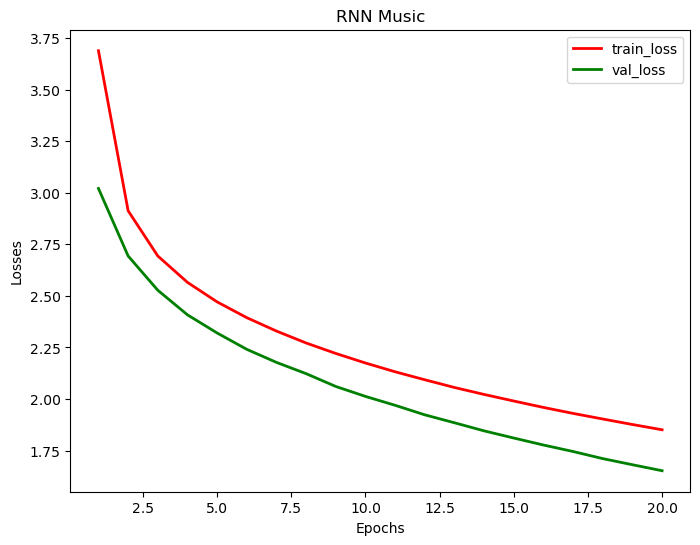

In [ ]:
# adapt loss and optimizer as needed
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_rnn.parameters(), lr=lr)

train_losses = []
valid_losses = []

# train
for epoch in range(epochs):
    # Set to train
    model_rnn.train()
    # keep cumalitive losses
    total_losses = 0.0

    for batch in training_dataloader:
        inp = batch[:, :-1] # grabs all but last
        tgt = batch[:, 1:] # grabs all except first (shifted once)

        optimizer.zero_grad()

        preds = model_rnn.forward(inp) # make sure dimensions line up

        loss = criterion(preds.view(-1, vocab_len), tgt.reshape(-1))
        loss.backward()

        optimizer.step()

        total_losses += loss.item()

    train_losses.append(total_losses / len(training_dataloader))
    print(f"Epoch: {epoch}, Loss: {total_losses / len(training_dataloader)}")


    # Validation
    model_rnn.eval()

    total_valid_losses = 0.0

    with torch.no_grad():
        for batch in validation_dataloader:
            inp = batch[:, :-1] # grabs all but last
            tgt = batch[:, 1:] # grabs all except first (shifted once)

            preds = model_rnn.forward(inp) # make sure dimensions line up

            loss = criterion(preds.view(-1, vocab_len), tgt.reshape(-1))
            total_valid_losses += loss.item()

    valid_losses.append(total_valid_losses / len(validation_dataloader))
    print(f"Validation loss: {total_valid_losses / len(validation_dataloader)}")


Display_Plot(train_loss=train_losses, valid_loss=valid_losses, model_name="RNN Music")


In [14]:
# this just grabs a random batch and performs on it
for batch in validation_dataloader:
    bleh = generate_music(model_rnn, batch[0][:4], temperature=1.0)
    notes = [token_to_note[token] for token in bleh]
    print(print(notes))
    break

C:\Users\Austi\AppData\Local\Temp\ipykernel_2320\2880647662.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))


['noteB-4_1', 'noteG3_1/3', '</simul>', 'noteE4_1/3', 'noteA3_1/4', '<simul>', 'noteE4_1/4', 'noteG3_1/4', '</simul>', '<simul>', 'noteE4_1/4', 'noteB-3_1/4', 'noteC3_1/2', '</simul>', '<simul>', 'noteA4_1/4', 'noteA3_1/4', '</simul>', '<simul>', 'noteA5_1/4', 'noteG4_1/4', 'noteA3_1/4', '</simul>', '<simul>', 'noteB-5_1/4', 'noteE4_1/4', '</simul>', '<simul>', 'noteA5_1/4', 'noteA4_1/4', 'noteA3_1/4', '</simul>', '<simul>', 'noteA4_1', 'noteA5_1', 'noteA4_1/4', 'rest_2', '</simul>', '<simul>', 'noteF4_1/4', 'noteA3_1/4', '</simul>', '<simul>', 'noteA4_1/4', 'noteE4_1/4', '</simul>', '<simul>', 'noteD5_1/2', 'noteF3_1/4', '</simul>', 'noteA3_1/4', '<simul>', 'noteA4_1/2', 'rest_1/2', 'noteF3_1/4', '</simul>', 'noteA3_1/4', '<simul>', 'noteG4_1/2', 'rest_1', 'noteD3_1/4', '</simul>', 'noteA3_1/4', '<simul>', 'rest_1', 'noteF4_1', 'noteD3_1/4', '</simul>', 'noteA3_1/4', 'noteA3_1/4', 'noteC4_1/4', '<simul>', 'noteA4_1/4', 'noteA3_1/4', '</simul>', '<simul>', 'noteA5_1/4', 'noteA3_1/4', '

In [ ]:
#save model
torch.save(model_rnn.state_dict(), "music_rnn_model.pth")


# LSTM

In [33]:
class MusicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3,):
        super(MusicLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)                            # [batch, seq_len] → [batch, seq_len, embed_dim]
        output, hidden = self.lstm(x, hidden)            # output: [batch, seq_len, hidden_dim]

        output = self.layer_norm(output)                 # Normalize LSTM output
        output = self.dropout(output)         
        # Apply dropout
        output = self.fc(output[:, :, :])           # Only final timestep → [batch, vocab_size]

        return output, hidden

In [34]:
model_lstm = MusicLSTM(vocab_len, input_size, hidden_size, num_layers=2, dropout=dropout).to(device)

Epoch 1, Train Loss: 3.8641
Validation Loss: 3.1784
Epoch 2, Train Loss: 3.0098
Validation Loss: 2.7678
Epoch 3, Train Loss: 2.7155
Validation Loss: 2.5349
Epoch 4, Train Loss: 2.5229
Validation Loss: 2.3621
Epoch 5, Train Loss: 2.3759
Validation Loss: 2.2287
Epoch 6, Train Loss: 2.2491
Validation Loss: 2.1046
Epoch 7, Train Loss: 2.1416
Validation Loss: 2.0046
Epoch 8, Train Loss: 2.0432
Validation Loss: 1.9041
Epoch 9, Train Loss: 1.9530
Validation Loss: 1.8224
Epoch 10, Train Loss: 1.8692
Validation Loss: 1.7206
Epoch 11, Train Loss: 1.7894
Validation Loss: 1.6536
Epoch 12, Train Loss: 1.7200
Validation Loss: 1.5708
Epoch 13, Train Loss: 1.6484
Validation Loss: 1.4883
Epoch 14, Train Loss: 1.5859
Validation Loss: 1.4260
Epoch 15, Train Loss: 1.5231
Validation Loss: 1.3594
Epoch 16, Train Loss: 1.4677
Validation Loss: 1.2992
Epoch 17, Train Loss: 1.4124
Validation Loss: 1.2372
Epoch 18, Train Loss: 1.3612
Validation Loss: 1.2145
Epoch 19, Train Loss: 1.3156
Validation Loss: 1.1339
Ep

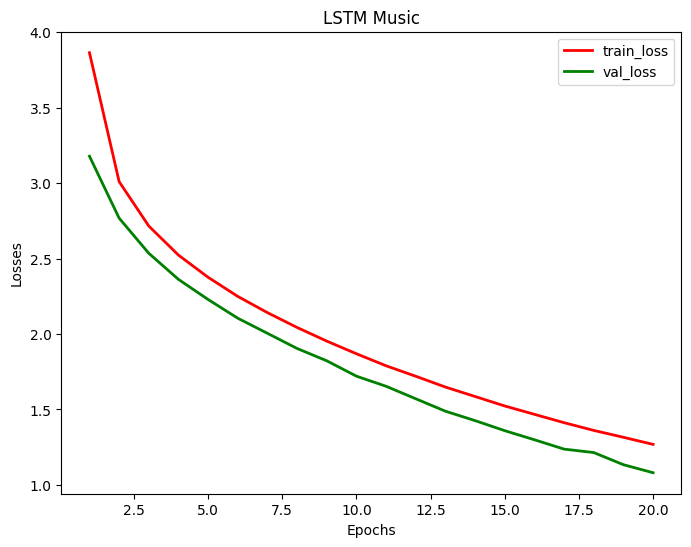

In [35]:
# adapt loss and optimizer as needed
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_lstm.parameters(), lr=lr)

train_losses = []
valid_losses = []

for epoch in range(epochs):
    model_lstm.train()
    total_losses = 0.0

    for batch in training_dataloader:
        batch = batch.to(device)
        inp = batch[:, :-1]         # input: [batch, seq_len - 1]
        tgt = batch[:, 1:]          # target: [batch]

        optimizer.zero_grad()

        preds, _ = model_lstm(inp)  # output: [batch, seq_len-1, vocab_size]

        # Reshape for CrossEntropyLoss: [batch * seq_len, vocab_size] vs [batch * seq_len]
        loss = criterion(preds.view(-1, vocab_len), tgt.reshape(-1))
        loss.backward()
        optimizer.step()

        total_losses += loss.item()

    avg_train_loss = total_losses / len(training_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}")

    # Validation loop
    model_lstm.eval()
    total_valid_losses = 0.0

    with torch.no_grad():
        for batch in validation_dataloader:
            batch = batch.to(device)
            inp = batch[:, :-1]         # input: [batch, seq_len - 1]
            tgt = batch[:, 1:]          # target: [batch]

            preds, _ = model_lstm(inp)
            loss = criterion(preds.view(-1, vocab_len), tgt.reshape(-1))
            total_valid_losses += loss.item()

    avg_valid_loss = total_valid_losses / len(validation_dataloader)
    valid_losses.append(avg_valid_loss)
    print(f"Validation Loss: {avg_valid_loss:.4f}")

# Display training curve
Display_Plot(train_loss=train_losses, valid_loss=valid_losses, model_name="LSTM Music")


In [37]:
'''
def generate_music_lstm(model, start_tokens, temperature=1.0, num_to_generate=100, window_length=window_length, end_token=None):
    model.eval()

    # Ensure start_tokens is a tensor on correct device
    if isinstance(start_tokens, torch.Tensor):
        predicted_tokens = start_tokens.clone().detach().unsqueeze(0).to(next(model.parameters()).device)
    else:
        predicted_tokens = torch.tensor(start_tokens, dtype=torch.long).unsqueeze(0).to(next(model.parameters()).device)

    for _ in range(num_to_generate):
        with torch.no_grad():
            # Use only the last `window_length` tokens
            input_seq = predicted_tokens[:, -window_length:]  # shape: [1, window_length]

            logits, _ = model(input_seq)                      # shape: [1, vocab_size]
            probs = torch.softmax(logits / temperature, dim=-1)  # shape: [1, vocab_size]
            pred_token = torch.multinomial(probs, num_samples=1)  # shape: [1, 1]

        # Append the predicted token
        predicted_tokens = torch.cat([predicted_tokens, pred_token], dim=1)

        # Optional early stopping on <end> token
        if end_token is not None and pred_token.item() == end_token:
            break

    return predicted_tokens.squeeze(0).tolist()

for batch in validation_dataloader:
    # Take the first 10 tokens from the first sample in the batch
    start = batch[0][:10]  # tensor of shape [10]
    generated = generate_music_lstm(
        model=model_lstm,
        start_tokens=start,
        temperature=1.0,
        num_to_generate=200,
        window_length=32,
        end_token=end_token  # Optional: pass if you have <end> token defined
    )

    notes = [token_to_note[token] for token in generated]
    print(notes)
    break
'''

'\ndef generate_music_lstm(model, start_tokens, temperature=1.0, num_to_generate=100, window_length=window_length, end_token=None):\n    model.eval()\n\n    # Ensure start_tokens is a tensor on correct device\n    if isinstance(start_tokens, torch.Tensor):\n        predicted_tokens = start_tokens.clone().detach().unsqueeze(0).to(next(model.parameters()).device)\n    else:\n        predicted_tokens = torch.tensor(start_tokens, dtype=torch.long).unsqueeze(0).to(next(model.parameters()).device)\n\n    for _ in range(num_to_generate):\n        with torch.no_grad():\n            # Use only the last `window_length` tokens\n            input_seq = predicted_tokens[:, -window_length:]  # shape: [1, window_length]\n\n            logits, _ = model(input_seq)                      # shape: [1, vocab_size]\n            probs = torch.softmax(logits / temperature, dim=-1)  # shape: [1, vocab_size]\n            pred_token = torch.multinomial(probs, num_samples=1)  # shape: [1, 1]\n\n        # Append t

In [47]:
# generate music
# for now, generate a fixed length, if we add start and end tokens then we can also do that
def generate_music_lstm(model, start_tokens, temperature=1.0, num_to_generate=window_length):
    model.eval()

    predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))
    # iteratively predict then add to start_tokens
    for i in range(num_to_generate):
        with torch.no_grad():
            # grab most recent tokens
            logits, _ = model(predicted_tokens[:, -(window_length):]) # (1, len(predicted_tokens), num_tokens)
            logits = logits[:, -1, :] # grabs last token 
            probs = torch.softmax(logits / temperature, dim=-1) # (1, num_tokens)
            pred_token = torch.multinomial(probs, num_samples=1) # (1, 1)

        predicted_tokens = torch.cat([predicted_tokens, pred_token], dim=1) # (1, len(current sequence length))

    return predicted_tokens.squeeze(0).tolist()

In [48]:
# this just grabs a random batch and performs on it
for batch in validation_dataloader:
    bleh = generate_music_lstm(model_lstm, batch[0][:4], temperature=1.0)
    notes = [token_to_note[token] for token in bleh]
    print(print(notes))
    break

/tmp/ipykernel_917778/3445894734.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))


['noteE4_1/4', '</simul>', 'noteC3_1/16', 'noteB-2_1/16', 'noteC3_1/16', 'noteC#3_1/16', 'noteC2_1/16', 'noteC3_1/16', '<simul>', 'rest_1/16', 'rest_1/16', '</simul>', '<simul>', 'rest_1', 'noteC3_1/2', '</simul>', 'noteF3_1/16', '<simul>', 'rest_1/16', 'rest_1/16', '</simul>', 'noteF3_1/16', 'noteG3_1/16', 'noteB-5_1/16', 'noteF3_1/16', '<simul>', 'rest_1/16', 'rest_1/16', '</simul>', 'noteF3_1/16', '<simul>', 'rest_1/16', 'rest_1/16', '</simul>', 'noteC4_1/16', 'noteC3_1/16', 'noteC3_1/16', 'noteF3_1/16', '<simul>', 'noteC3_1/16', 'noteG#1_1/2', '</simul>', 'noteF3_1/16', '<simul>', 'noteF4_1/16', 'noteF3_1/16', '</simul>', 'noteF3_1/16', 'noteF5_1/16', 'noteA3_1/16', 'noteF3_1/16', 'noteE-3_1/16', 'noteF3_1/16', 'noteD4_1/16', 'noteF3_1/16', '<simul>', 'noteB-3_1/4', 'rest_1/2', '</simul>', 'noteG#3_1/4', 'noteF3_1/16', 'noteB-3_1/16', 'noteF3_1/16', 'noteF3_1/16', '<simul>', 'noteB-3_1/4', 'rest_1/2', 'noteE-2_1/2', '</simul>', 'noteF3_1/16', 'noteF2_1/16', 'noteF3_1/16', 'noteE-3_

In [49]:
torch.save(model_lstm.state_dict(), "music_lstm_model.pth")

# Transformer

YAYYYYYYYYY Transformer Time WOOOOOOOOO

In [8]:
#  Model variables
d_model = 128 # Embed Dim
n_decoder_layers = 4 # lower if not that complex and wanting speedup
n_heads = 4 # Number of Attention Heads
d_ff = 512 # Feed Forward Dimensionality (AIAYN paper reccomends 4 times d_model size)
learning_rate = 1e-4 # Maybe increase?
num_epochs = 20 # Change this later so it doesn't take 10 years to run

In [9]:
# Standard positonal encoding used here, could also try time encoding since notes have different timestamps
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, win_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(win_len, d_model) # (win_len, d_model)
        position = torch.arange(0, win_len, dtype=torch_type).unsqueeze(1) # (win_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-torch.log(torch.tensor(10000.0))/d_model)) # (d_model/2)
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0) # (1, win_len, d_model)
        self.pe = pe.to(device)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x


# mask
def generate_causal_mask(size):
    # size should be target size
    mask = torch.triu(torch.ones(size, size, device=device), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    '''
    [0, -inf, -inf, -inf]
    [0,   0,  -inf, -inf]
    [0,   0,    0,  -inf]
    [0,   0,    0,    0 ]
    Yay for triangle masking
    '''
    return mask


In [10]:
# Actual decoder
class MusicTransformer(nn.Module):
    def __init__(self, num_tokens, d_model=d_model, nhead=n_heads, dim_ff=d_ff, win_len=window_length, layers=n_decoder_layers):
        super(MusicTransformer, self).__init__()
        self.d_model = d_model
        self.nheads = nhead
        self.dim_ff = dim_ff
        self.win_len = win_len
        self.layers = layers

        # pre-transformer
        self.tok_embed = nn.Embedding(num_tokens, d_model)
        self.pos_enc = PositionalEncoding(d_model, win_len)
        self.out_proj = nn.Linear(d_model, num_tokens) # final projection for token prediction

        # transformer part
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_ff, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=self.layers)


    def forward(self, x, tgt_mask=None):
        '''
        x is the tokenized notes  # (batch_size, win_len)
        tgt_mask masks the predictions
        '''

        x_seq = self.tok_embed(x) # (batch_size, 1, d_model)
        x_seq = self.pos_enc(x_seq) # (batch_size, 1, d_model)

        decoder_output = self.decoder(x_seq, x_seq, tgt_mask=tgt_mask) # (batch_size, win_len, d_model)
        pred = self.out_proj(decoder_output) # (batch, win_len, num_tokens) 
      
        return pred




Epoch [1/20]


Training Loss: 0.1980


Validation Loss: 0.0057

Epoch [2/20]


Training Loss: 0.0056


Validation Loss: 0.0049

Epoch [3/20]


Training Loss: 0.0050


Validation Loss: 0.0046

Epoch [4/20]


Training Loss: 0.0047


Validation Loss: 0.0044

Epoch [5/20]


Training Loss: 0.0046


Validation Loss: 0.0042

Epoch [6/20]


Training Loss: 0.0044


Validation Loss: 0.0041

Epoch [7/20]


Training Loss: 0.0043


Validation Loss: 0.0040

Epoch [8/20]


Training Loss: 0.0042


Validation Loss: 0.0039

Epoch [9/20]


Training Loss: 0.0041


Validation Loss: 0.0038

Epoch [10/20]


Training Loss: 0.0040


Validation Loss: 0.0037

Epoch [11/20]


Training Loss: 0.0039


Validation Loss: 0.0037

Epoch [12/20]


Training Loss: 0.0039


Validation Loss: 0.0036

Epoch [13/20]


Training Loss: 0.0038


Validation Loss: 0.0036

Epoch [14/20]


Training Loss: 0.0037


Validation Loss: 0.0035

Epoch [15/20]


Training Loss: 0.0037


Validation Loss: 0.0035

Epoch [16/20]


Training Loss: 0.0037


Validation Loss: 0.0034

Epoch [17/20]


Training Loss: 0.0036


Validation Loss: 0.0034

Epoch [18/20]


Training Loss: 0.0036


Validation Loss: 0.0034

Epoch [19/20]


Training Loss: 0.0035


Validation Loss: 0.0033

Epoch [20/20]


Training Loss: 0.0035


Validation Loss: 0.0033


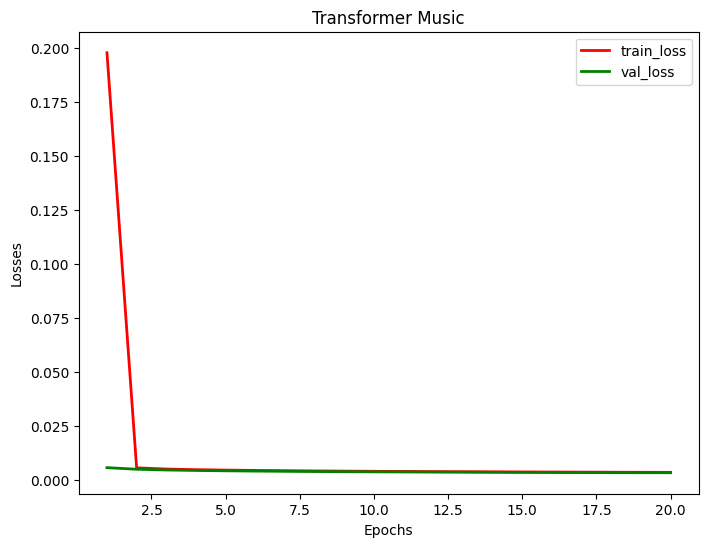

In [25]:
my_mask = generate_causal_mask(window_length) # win_len by win_len mask

# Create model
num_tokens = vocab_len
model = MusicTransformer(num_tokens, d_model, n_heads, d_ff, window_length, n_decoder_layers).to(device)

# Use Adam cause he's so cool
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

transformer_train_losses = []
transformer_valid_losses = []

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     epoch_loss = 0 # cumalative loss


#     # Cycle through each batch
#     for batch in training_dataloader:
#         inp = batch[:, :-1] # grabs all but last
#         tgt = batch[:, 1:] # grabs all except first (shifted once)


#         optimizer.zero_grad()
#         # Pass through model
#         output = model(inp)
#         # Determine loss
#         loss = criterion(output.contiguous().view(-1, num_tokens), tgt.reshape(-1))
#         # Update weights
#         loss.backward()
#         optimizer.step()
#         # Add to epoch_loss
#         epoch_loss += loss.item()

#     # Now show average loss for epoch
#     avg_epoch_loss = epoch_loss / len(training_dataloader)
#     transformer_train_losses.append(avg_epoch_loss)
#     print(f"Epoch: [{epoch+1}/{num_epochs}]   Epoch Average Loss: {avg_epoch_loss}")



#     # Validation
#     model.eval()
#     valid_loss = 0 # cumalative loss

#     # Cycle through each batch
#     for batch in validation_dataloader:
#         inp = batch[:, :-1] # grabs all but last
#         tgt = batch[:, 1:] # grabs all except first (shifted once)

#         # Pass through model
#         output = model(inp)
#         # Determine loss
#         loss = criterion(output.view(-1, num_tokens), tgt.reshape(-1))
#         valid_loss += loss.item()
#     # Now show average loss for 
#     avg_epoch_loss = valid_loss / len(validation_dataloader)
#     transformer_valid_losses.append(avg_epoch_loss)
#     print(f"Validation Loss: {avg_epoch_loss}")

from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # cumulative loss

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    for batch in tqdm(training_dataloader, desc="Training", leave=False):
        inp = batch[:, :-1]
        tgt = batch[:, 1:]

        optimizer.zero_grad()
        output = model(inp)
        loss = criterion(output.contiguous().view(-1, num_tokens), tgt.reshape(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(training_dataloader)
    transformer_train_losses.append(avg_epoch_loss)
    print(f"Training Loss: {avg_epoch_loss:.4f}")

    # Validation
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc="Validation", leave=False):
            inp = batch[:, :-1]
            tgt = batch[:, 1:]

            output = model(inp)
            loss = criterion(output.view(-1, num_tokens), tgt.reshape(-1))
            valid_loss += loss.item()

    avg_valid_loss = valid_loss / len(validation_dataloader)
    transformer_valid_losses.append(avg_valid_loss)
    print(f"Validation Loss: {avg_valid_loss:.4f}")




Display_Plot(train_loss=transformer_train_losses, valid_loss=transformer_valid_losses, model_name="Transformer Music")

In [26]:
torch.save(model.state_dict(), "music_transformer_model.pth")

In [21]:
from collections import Counter
# generate music
# for now, generate a fixed length, if we add start and end tokens then we can also do that
def generate_music(model, start_tokens, temperature=1.0, repitition_penalty=1.0, recent_window=5, num_to_generate=window_length+500):
    model.eval()

    predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))
    # iteratively predict then add to start_tokens
    for i in range(num_to_generate):
        with torch.no_grad():
            # grab most recent tokens
            logits = model(predicted_tokens[:, -(window_length):]) # (1, len(predicted_tokens), num_tokens)
            logits = logits[:, -1, :] # grabs last token 
            # apply repitition penalty
            recent_tokens = predicted_tokens[0, -recent_window:].tolist()
            c = Counter(recent_tokens)
            for token_id in recent_tokens:
                logits[0, token_id] -= repitition_penalty * pow(2, c[token_id])
            # grab probs
            probs = torch.softmax(logits / temperature, dim=-1) # (1, num_tokens)
            pred_token = torch.multinomial(probs, num_samples=1) # (1, 1)

        predicted_tokens = torch.cat([predicted_tokens, pred_token], dim=1) # (1, len(current sequence length))

    return predicted_tokens.squeeze(0).tolist()


In [ ]:
# this just grabs a random batch and performs on it
for batch in validation_dataloader:
    bleh = generate_music(model, batch[0][:window_length], temperature=1.0)
    notes = [token_to_note[token] for token in bleh]
    print(print(notes[window_length:]))
    break

/tmp/ipykernel_949026/130915328.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))


['3/2', 'noteB-3', '1/2', 'noteC#5', '1/8', '</simul>', '<simul>', 'noteE-5', '1/2', '</simul>', '<simul>', 'noteC#5', '1/8', 'rest', '3', 'noteF#5', '1/2', '</simul>', '<simul>', 'noteB-4', '1', 'noteF3', '1/2', 'noteG#3', 'noteF#0', '<simul>', 'noteC#5', '1', 'noteF#4', '1/2', 'noteD4', '3', 'noteB-3', '3/2', 'noteF2', '1/2', '</simul>', '<simul>', 'noteF#5', '1/2', '</simul>', '<simul>', 'noteB-4', '1/2', 'noteE1', '1', 'noteG#4', '3', '</simul>', '<simul>', 'noteE-5', '1/2', '</simul>', 'noteE-2', '3/2', 'rest', '1/2', 'noteF#3', '1', 'noteD2', '3/2', '</simul>', '<simul>', 'noteE-5', '1/2', 'noteG#3', '3/2', '</simul>', '<simul>', 'noteF#2', '1/2', '</simul>', '<simul>', 'noteD4', '1/2', '</simul>', '<simul>', 'noteE-3', '3/2', 'noteG#3', '1/3', '</simul>', '<simul>', 'noteE-5', '1/2', 'noteG3', '3/2', 'noteG#3', '1', '</simul>', '<simul>', 'rest', '3', 'noteB3', '1/2', 'noteF#2', '3/2', 'noteG#5', '1/2', '</simul>', '<simul>', 'noteD3', '1', 'noteC#2', '3/2', '</simul>', '<simul>

# Final Comparisons

When starting this project, we assumed that the Transformer model would perform the best; it's ability to scale and use attention should (in theory) perform much better for music data than the simpler RNN or LSTM. However, we found that the performance increase was not incredible, especially after adapting the model architecture of them all. We believe this might be due to a lack of data, as well as our tokenization methods keeping the note and length together. Future work might divide these into individual tokens, and apply a different encoding technique so that the transformer has more to work with.

For the RNN, the losses start at 4, and it eventually goes down to 1.65. We had to change the architecture a lot, but we did not see a lot of overfitting. Improvements start slowing down after epoch 20.

For the LSTM, the losses started at 4, then went down to 1.1. We originally had a bug in our training loop, which led us to overfit heavily, so we tried many different model architectures before fixing the bug. Once we did, the overfitting problem was solved. Improvements slowed down drastically upon reaching epoch 20, so we used that for training. Of the models, this seemed to perform the best.

For the transformer, the losses started out decently high (4.5) but fell very quickly. Despite using the standard dropout, 0.1, we did not observe much overfitting. The validation loss stayed under the training loss the entire time. Notably, the model continued to perform well even after epoch 20, so we increased the amount of epochs to 30, after which the model performance started tapering off. Final validation loss was around 1.34.